In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
from nsb.core import Frame, Model

from nsb.instrument import HESS
from nsb.atmosphere import scattering, extinction

from nsb.emitter import moon, stars, airglow, galactic, zodiacal
import nsb.utils.plots as uplot

In [5]:
%load_ext snakeviz
%snakeviz_config -h localhost -p 31159

In [6]:
from tools.flatfielding import FlatFieldModel
from tools.pointing import PointingModel
from tools.utils import hap2cta

['/home/gerritr/ECAP/nsb_simulation/nsb2/examples', '/home/gerritr/ECAP/nsb_simulation', '/home/gerritr/ECAP/nsb_simulation/nsb2', '/home/gerritr/ECAP/nsb_simulation/nsb2/examples', '/usr/local/lib/python311.zip', '/usr/local/lib/python3.11', '/usr/local/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/site-packages', '/home/hfm/hess/hap-18-11/']


# Predicting Night Sky Background for H.E.S.S.

## 1. Configuring the model layers:

Configuring the models for emitters:

In [7]:
cachepath = '/home/gerritr/ECAP/nsb_simulation/data/'

# Moonlight:
conf_jons = {}

# Diffuse Emitters:
conf_glow = {"H": 87}
conf_gbl  = {"Mag_0": 562.53*2.3504*1e-11}
conf_zodi = {}

# Starlight
conf_hipp = {"cache_path": cachepath,
             "magmin": -1.5,
             "magmax": 8,
             "Mag_0": 143.18*2.3504*1e-11,
             "cache": True}

conf_gaia = {"cache_path": cachepath,
             "magmin" : 8,
             "magmax": 15,
             "Mag_0": 562.53*2.3504*1e-11,
             "cache": True}

Configuring atmospheric scattering:

In [8]:
conf_mie = {"parameters": [0.8],
            "bins": [np.linspace(0, np.pi, 1000)]}      
conf_ray = {"parameters": [0.0148],
            "bins": [np.linspace(0, np.pi, 1000)]}
conf_masana = {'gamma':1}
conf_noll = {'scale':1., 'offset':0.4}

Configuring telescope scattering layer (for CT1):

In [9]:
c_bins = [np.linspace(0, np.deg2rad(3), 50), np.linspace(0, 2*np.pi, 20), np.linspace(0, np.deg2rad(2), 100)]
conf_cornils = {"parameters": [0.1, np.deg2rad(2.5)], 'bins': c_bins, 'degradation':0.75}

## 2. Creating a model:
### Defining simple model including Moon, Stars and Airglow:

In [10]:
# Sources:
glow = airglow.Noll2012(conf_glow)
zodi = zodiacal.Masana2021(conf_zodi)

hipp = stars.Hipparcos(conf_hipp)
gaia = stars.GaiaDR3(conf_gaia)
gbl  = galactic.GaiaDR3Mag15(conf_gbl)

jons = moon.Jones2013(conf_jons)

# Atmospheric Extinction:
atm_airglow = extinction.Masana2021(conf_masana)([glow])
atm_diffuse = extinction.Masana2021(conf_masana)([zodi, gbl])
atm_stellar = extinction.Masana2021(conf_masana)([gaia, hipp])

# Atmospheric Scattering:
atm_ray = scattering.Rayleigh(conf_ray)([jons]).map(np.deg2rad(180))
atm_mie = scattering.Mie(conf_mie)([jons]).map(np.deg2rad(180))

# Instrument:
cornils_df = HESS.Cornils2003(conf_cornils, 1)([atm_ray, atm_mie, atm_diffuse, atm_airglow])
cornils_st = HESS.Cornils2003(conf_cornils, 50)([atm_stellar])

# Camera:
CT1 = HESS.CT1(3)([cornils_df, cornils_st])

### Compiling the model:

In [11]:
%%time
model = Model(CT1)
model.compile()

CPU times: user 1min 13s, sys: 1.52 s, total: 1min 15s
Wall time: 1min 17s


### Visualizing the pipeline

In [12]:
print(model.summary())

defaultdict(<class 'list'>, {<nsb.instrument.HESS.CT1 object at 0x7fd4039bf890>: [<nsb.instrument.HESS.Cornils2003 object at 0x7fd40394a5d0>, <nsb.instrument.HESS.Cornils2003 object at 0x7fd4039bf910>], <nsb.instrument.HESS.Cornils2003 object at 0x7fd40394a5d0>: [<nsb.atmosphere.scattering.Rayleigh object at 0x7fd4039bfb50>, <nsb.atmosphere.scattering.Mie object at 0x7fd4039bfa50>, <nsb.atmosphere.extinction.Masana2021 object at 0x7fd4039bfd50>, <nsb.atmosphere.extinction.Masana2021 object at 0x7fd4039bfd10>], <nsb.atmosphere.scattering.Rayleigh object at 0x7fd4039bfb50>: [<nsb.emitter.moon.Jones2013 object at 0x7fd40394af10>], <nsb.atmosphere.scattering.Mie object at 0x7fd4039bfa50>: [<nsb.emitter.moon.Jones2013 object at 0x7fd40394af10>], <nsb.atmosphere.extinction.Masana2021 object at 0x7fd4039bfd50>: [<nsb.emitter.zodiacal.Masana2021 object at 0x7fd40394a690>, <nsb.emitter.galactic.GaiaDR3Mag15 object at 0x7fd403e90350>], <nsb.atmosphere.extinction.Masana2021 object at 0x7fd4039bfd

## 3. Determining a frame to capture:
A "frame" describing a capture is determined by:
 - A location
 - An observation time in UTC
 - A target at which to point

In [34]:
location = EarthLocation.from_geodetic(16.5028, -23.27280, 1800.)
obstime  = astropy.time.Time('2021-03-21T22:14:16', format='isot', scale='utc')
altaz  = AltAz(obstime=obstime, location=location)
#target   = SkyCoord(dec = -59.01192496, ra = 161.21859696, unit='deg', frame='icrs').transform_to(altaz)
target   = SkyCoord.from_name('eta car').transform_to(altaz)

frame = Frame(altaz, target, 3, albedo=0.9, aero=[0.065, 1.6], sfu=75)
frame.obswl = np.linspace(270, 730, 15)*u.nm

## 4. Using the model to predict NSB

In [38]:
res = model.predict(frame)

## 5. Visualizing the data:
Each pipeline layer has it's corresponding visualization. It can either be called on a frame or rays generated by the same layer. As such, the final data can be easily evaluated:

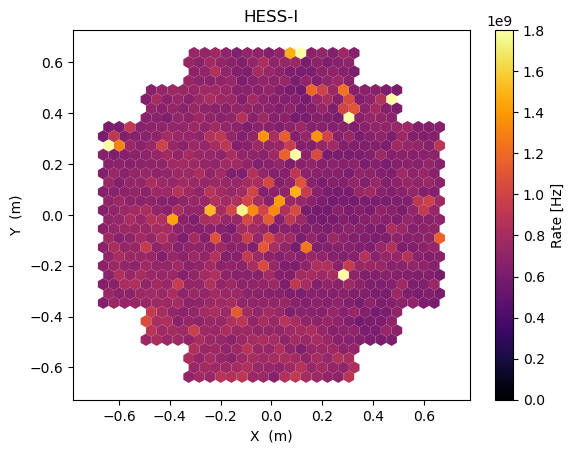

In [40]:
fig, ax = plt.subplots()
disp = CT1.display(res, ax, 'Rate [Hz]', show_frame=False)
disp.set_limits_minmax(0, 1.8e9)

### Individual contributions:

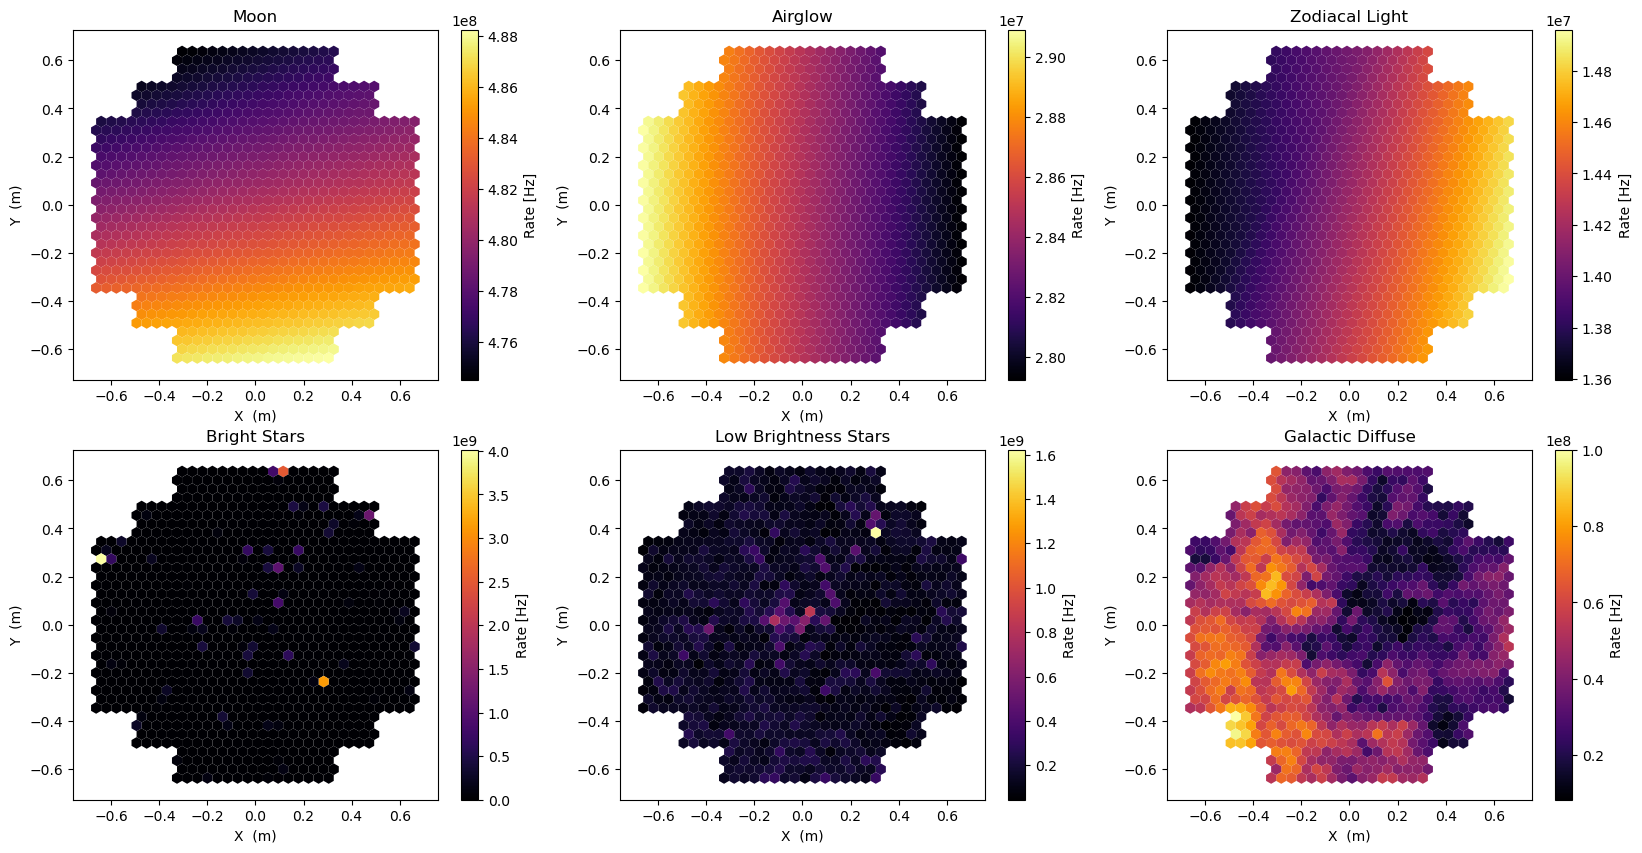

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
disp1 = CT1.display(res[res.source == type(jons)], ax[0,0], 'Rate [Hz]', title='Moon', show_frame=False)
disp2 = CT1.display(res[res.source == type(glow)], ax[0,1], 'Rate [Hz]', title='Airglow', show_frame=False)
disp3 = CT1.display(res[res.source == type(zodi)], ax[0,2], 'Rate [Hz]', title='Zodiacal Light', show_frame=False)
disp4 = CT1.display(res[res.source == type(hipp)], ax[1,0], 'Rate [Hz]', title='Bright Stars', show_frame=False)
disp5 = CT1.display(res[res.source == type(gaia)], ax[1,1], 'Rate [Hz]', title='Low Brightness Stars', show_frame=False)
disp6 = CT1.display(res[res.source == type(gbl)], ax[1,2], 'Rate [Hz]', title='Galactic Diffuse', show_frame=False)